### CNN
* http://andrew.gibiansky.com/blog/machine-learning/convolutional-neural-networks/
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721
* https://algotravelling.com/ru/%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5-%D1%8D%D1%82%D0%BE-%D0%B2%D0%B5%D1%81%D0%B5%D0%BB%D0%BE-3/
* https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
* https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b
* https://github.com/udsclub/images-classification-caltech
* https://www.asozykin.ru/courses/nnpython

### Preprocessing
* https://www.embedded-vision.com/sites/default/files/apress/computervisionmetrics/chapter2/9781430259299_Ch02.pdf
* https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network
* https://www.quora.com/What-are-some-ways-of-pre-procesing-images-before-applying-convolutional-neural-networks-for-the-task-of-image-classification
* http://cs231n.github.io/neural-networks-2/#datapre
* http://www.robots.ox.ac.uk/~vgg/practicals/cnn/#getting-started
* https://www.safaribooksonline.com/library/view/programming-computer-vision/9781449341916/ch01.html
* https://stackoverflow.com/a/10169025/5151861
* augmentation tf+keras http://machinelearningmastery.com/image-augmentation-deep-learning-keras/

#### Augmentation
* rotation: random with angle between 0° and 360° (uniform)
* translation: random with shift between -10 and 10 pixels (uniform)
* rescaling: random with scale factor between 1/1.6 and 1.6 (log-uniform)
* flipping: yes or no (bernoulli)
* shearing: random with angle between -20° and 20° (uniform)
* stretching: random with stretch factor between 1/1.3 and 1.3 (log-uniform)

* Gaussian blurring of images
* Morphology—Counting Objects

Ресайзинг - важно
* http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial

* одну- дву- слойную cnn
* графики ошибки
* 224х224
* 32х32
* в керас
* серые картинки 
* тензор борд
* презентация по аугментации

whitening

In [1]:
from scipy import ndimage
import numpy as np
import pandas as pd
import os
from IPython.display import display, Image
import scipy
import matplotlib.pyplot as plt
from skimage import io, transform
import skimage
from keras.preprocessing.image import ImageDataGenerator
import tensorflow

%matplotlib inline

Using TensorFlow backend.


In [39]:
pixel_depth = 255.0 # number of levels per pixel
num_classes = 257 # number of total classes
test_folder = 'data/test' # dir, where test set is placed
train_folder = 'data/train' # dir, where train set is placed
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100

In [3]:
def reshape(img):
    nsamples, nx, ny = img.shape
    return img.reshape((nsamples,nx*ny))

In [4]:
def norm(img):
    img -= np.mean(img, axis = 0)
    img /= np.std(img, axis = 0)
    return img

In [111]:
def resize(img):
    shape = (IMAGE_WIDTH, IMAGE_HEIGHT)
    size = skimage.transform.resize(img, shape)

In [241]:
def load_train_set(df):
    folders = os.listdir(train_folder)
    for ind, folder in enumerate(folders):
        #if ind % 60 == 0:
            folder = os.path.join(train_folder, folder)
            print('{}'.format(folder))
            if os.path.isdir(folder):
                image_files = os.listdir(folder)
                for image_file in image_files:
                    if not image_file.startswith('.'):
                        image = io.imread(os.path.join(folder, image_file))
                        #image = resize(image)
                        #image = norm(image)
                        #target = folder.split('.')[0].split('/')[2]
                        target = int(folder.split('.')[0].split('/')[2])
                        df.loc[df.shape[0]]=[folder[15:], image_file, image.shape[0], image.shape[1], image.dtype, target]

In [234]:
df = pd.DataFrame(columns = ['category', 'image_name', 'width', 'height', 'type', 'target'])

In [235]:
train_set = load_train_set(df)

data/train/.DS_Store
data/train/001.ak47
data/train/002.american-flag
data/train/003.backpack
data/train/004.baseball-bat
data/train/005.baseball-glove
data/train/006.basketball-hoop
data/train/007.bat
data/train/008.bathtub
data/train/009.bear
data/train/010.beer-mug
data/train/011.billiards
data/train/012.binoculars
data/train/013.birdbath
data/train/014.blimp
data/train/015.bonsai-101
data/train/016.boom-box
data/train/017.bowling-ball
data/train/018.bowling-pin
data/train/019.boxing-glove
data/train/020.brain-101
data/train/021.breadmaker
data/train/022.buddha-101
data/train/023.bulldozer
data/train/024.butterfly
data/train/025.cactus
data/train/026.cake
data/train/027.calculator
data/train/028.camel
data/train/029.cannon
data/train/030.canoe
data/train/031.car-tire
data/train/032.cartman
data/train/033.cd
data/train/034.centipede
data/train/035.cereal-box
data/train/036.chandelier-101
data/train/037.chess-board
data/train/038.chimp
data/train/039.chopsticks
data/train/040.cockroac

### Classes distribution

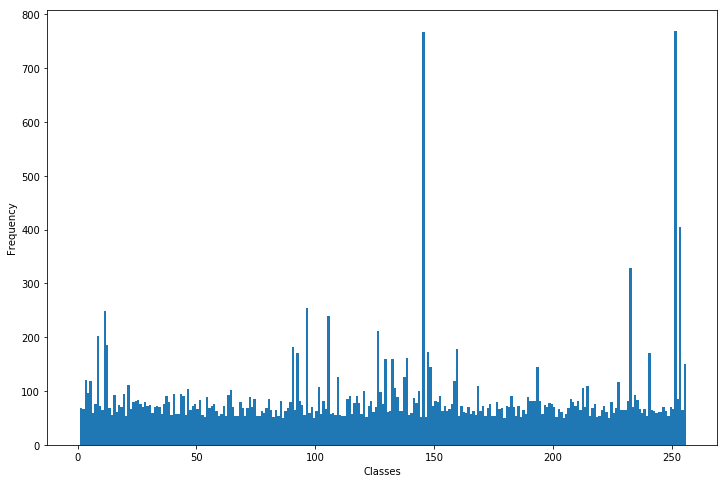

In [268]:
plt.figure(figsize=(12, 8))
plt.hist(df['target'], bins=range(len(df['target'].unique())))
plt.xlabel('Classes')
plt.ylabel('Frequency');

In [273]:
X = df
y = df['target']
df.to_csv('train_data');

In [ ]:
def load_test_set():
    num_images = 0
    images = os.listdir(test_folder)
    test_set = []
    for image in images:
        image = os.path.join(test_folder, image)
        test_set.append(io.imread(image))
    return test_set

In [ ]:
test_set = load_test_set()

In [ ]:
img = test_set[0]
shape = (IMAGE_WIDTH, IMAGE_HEIGHT)
size = skimage.transform.resize(img, shape)

In [ ]:
img.size

In [ ]:
scale = skimage.transform.rescale(img, 0.5)